# Evaluation and plotting for different experiments

- Write throughput (fio vs dd, isilon vs netapp)
- Containerized fio vs non-containerized fio

In [1]:
from __future__ import annotations
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from pathlib import Path
import scipy.stats as st
from datetime import datetime, timedelta

In [2]:
METRIC = {
    "throughput_write": "write_bw_mean_in_MiB",
    "iops_write": "write_iops_mean",
    "latency_write": "write_lat_mean_in_ms",
    "throughput_read": "read_bw_mean_in_MiB",
    "iops_read": "read_iops_mean",
    "latency_read": "read_lat_mean_in_ms",
}

def load_data(filename: Path | str, metric: str, suffix: str="") -> pd.DataFrame:
    """Load data either from file or from multiple files placed in a directory"""
    path = Path(filename)
    if path.is_file():
        data = load_json(path)
    elif path.is_dir():
        data = load_dir(path, suffix)
    else:
        data = load_json(str(path)+suffix)
    return extract_results(data, metric)

def load_json(filename: Path | str) -> dict:
    """Load file as json"""
    file = Path(filename)
    assert file.is_file(), f"{file} is not a file"
    return json.loads(file.read_text())

def load_dir(path: Path, suffix: str) -> dict:
    """Combine results of multiple files in directory. Specify files by suffix"""
    res = {"results":{}}

    for file in path.glob(f"*{suffix}"):
        data = load_json(file)

        for key, value in data["results"].items():
            if key not in res["results"]:
                res["results"][key] = []
            res["results"][key].extend(value)

    return res

def extract_results(data, metric, x_labels=None):
    x_labels = x_labels if x_labels else list(data["results"].keys())
    pd_data = []
    for label in x_labels:
        results = data["results"][label]
        values = [float(r[metric]) for r in results]
        mean = np.mean(values)
        conf = confidence_interval(values)
        pd_data.append([mean, conf])


    df = pd.DataFrame(data=pd_data, index=x_labels, columns=["mean", "conf"])
    df.rename(index={"1024": 1, "2048": 2, "4096": 4, "8192": 8, "16384": 16}, inplace=True)
    df.rename(index={"256M": 0.25, "1G": 1, "2G": 2, "4G": 4, "8G": 8, "16G": 16}, inplace=True)
    df.rename(index={"1k": 1, "4k": 4, "16k": 16, "64k": 64, "256k": 256, "1024k": 1024, "4096k": 4096, "16384k": 16384}, inplace=True)
    df.rename(index={"1": 1, "2": 2, "4": 4, "8": 8, "16": 16, "32": 32}, inplace=True)
    df.rename(index={"10": 10, "20": 20, "60": 60, "120": 120, "300": 300}, inplace=True)

    return df

def confidence_interval(values):
    confidence = 0.95
    dof = len(values)-1
    m = np.mean(values)
    sem = st.sem(values)
    interval = st.t.interval(alpha=confidence, df=dof, loc=m, scale=sem)
    if np.isnan(interval[0]) or np.isnan(interval[1]):
        return m * 10**-6
    return (interval[1]-interval[0])/2
    
def plot(filename, metric="write_bw_mean_in_mb"):
    data = load_json(filename)
    df = extract_results(data, metric=metric)
    print(df)
    ax = df["mean"].plot(kind='bar', rot=0, xlabel='Date', ylabel='Value', title='My Plot', figsize=(6, 4), yerr=df["conf"])
    plt.show()

def tex_table(lst):
    for item in lst:
        print(*item, sep=" & ", end="\\\\\n")

# Experiment: Parameter-evaluation: dd

<IPython.core.display.Javascript object>


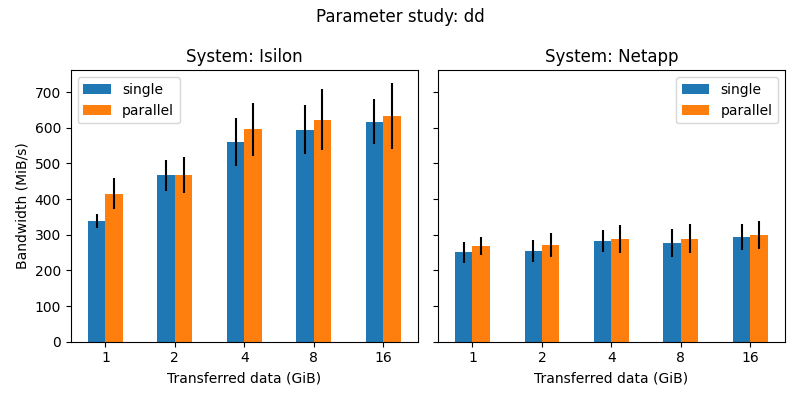

In [39]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T20:00:06_throughput_write_dd_")
folder = Path("./results/param_study_dd")

## Plot code
path = file_prefix if file_prefix else folder

df_isilon = pd.concat({
    "single": load_data(path, metric="bw_in_MiB", suffix="isilon_a.json"),
    "parallel": load_data(path, metric="bw_in_MiB", suffix="isilon_b.json"),
})

df_netapp = pd.concat({
    "single": load_data(path, metric="bw_in_MiB", suffix="netapp_a.json"),
    "parallel": load_data(path, metric="bw_in_MiB", suffix="netapp_b.json"),
})

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Parameter study: dd')

df_isilon["mean"].unstack(level=0)[["single","parallel"]].plot(
    ax=ax1,
    kind='bar', rot=0,
    xlabel='Transferred data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"System: Isilon",
    figsize=(8, 4),
    yerr=df_isilon["conf"].unstack(level=0)[["single","parallel"]]
)

df_netapp["mean"].unstack(level=0)[["single","parallel"]].plot(
    ax=ax2,
    kind='bar', rot=0,
    xlabel='Transferred data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"System: Netapp",
    figsize=(8, 4),
    yerr=df_netapp["conf"].unstack(level=0)[["single","parallel"]],
)

plt.tight_layout()
plt.savefig("paramstudy_dd.png",bbox_inches='tight')
plt.show()


# Experiment: Parameter-evaluation: Fio

<IPython.core.display.Javascript object>


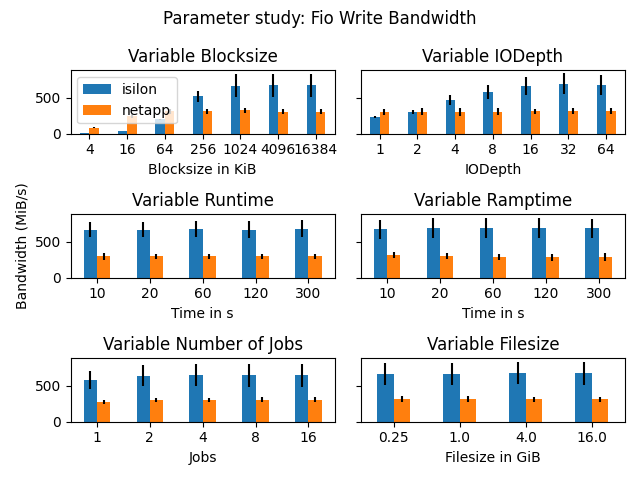

In [50]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-05-17T21:18:41_throughput_write_")
folder = Path("./results/param_study_fio_throughput")

## Plot code
path = file_prefix if file_prefix else folder


post_i = "_isilon.json"
post_n = "_netapp.json"
metric = METRIC["throughput_write"]

df_1 = pd.concat({
    "isilon": load_data(path, suffix="blocksize"+post_i, metric=metric),
    "netapp": load_data(path, suffix="blocksize"+post_n, metric=metric),
})
df_2 = pd.concat({
    "isilon": load_data(path, suffix="iodepth"+post_i, metric=metric),
    "netapp": load_data(path, suffix="iodepth"+post_n, metric=metric),
})
df_3 = pd.concat({
    "isilon": load_data(path, suffix="runtime"+post_i, metric=metric),
    "netapp": load_data(path, suffix="runtime"+post_n, metric=metric),
})
df_4 = pd.concat({
    "isilon": load_data(path, suffix="ramptime"+post_i, metric=metric),
    "netapp": load_data(path, suffix="ramptime"+post_n, metric=metric),
})
df_5 = pd.concat({
    "isilon": load_data(path, suffix="numjobs"+post_i, metric=metric),
    "netapp": load_data(path, suffix="numjobs"+post_n, metric=metric),
})
df_6 = pd.concat({
    "isilon": load_data(path, suffix="filesize"+post_i, metric=metric),
    "netapp": load_data(path, suffix="filesize"+post_n, metric=metric),
})

fig, axis = plt.subplots(3, 2, sharey=True)
fig.suptitle('Parameter study: Fio Write Bandwidth')

    
df_1["mean"].unstack(level=0).plot(
    ax=axis[0][0],
    kind='bar', rot=0,
    xlabel='Blocksize in KiB',
    title='Variable Blocksize',
    yerr=df_1["conf"].unstack(level=0)
)
df_2["mean"].unstack(level=0).plot(
    ax=axis[0][1],
    kind='bar', rot=0,
    xlabel='IODepth',
    title='Variable IODepth',
    yerr=df_2["conf"].unstack(level=0)
)

df_3["mean"].unstack(level=0).plot(
    ax=axis[1][0],
    kind='bar', rot=0,
    xlabel='Time in s',
    ylabel='Bandwidth (MiB/s)',
    title='Variable Runtime',
    yerr=df_3["conf"].unstack(level=0)
)

df_4["mean"].unstack(level=0).plot(
    ax=axis[1][1],
    kind='bar', rot=0,
    xlabel='Time in s',
    title='Variable Ramptime',
    yerr=df_4["conf"].unstack(level=0)
)
df_5["mean"].unstack(level=0).plot(
    ax=axis[2][0],
    kind='bar', rot=0,
    xlabel='Jobs',
    title='Variable Number of Jobs',
    yerr=df_5["conf"].unstack(level=0)
)
df_6["mean"].unstack(level=0).plot(
    ax=axis[2][1],
    kind='bar', rot=0,
    xlabel='Filesize in GiB',
    title='Variable Filesize',
    yerr=df_6["conf"].unstack(level=0)
)
for i,j in [(0,1),(1,0),(1,1),(2,0),(2,1)]:
    axis[i][j].get_legend().remove()
    
plt.tight_layout()
plt.savefig("paramstudy_fio_throughput.png",bbox_inches='tight')
plt.show()


<IPython.core.display.Javascript object>


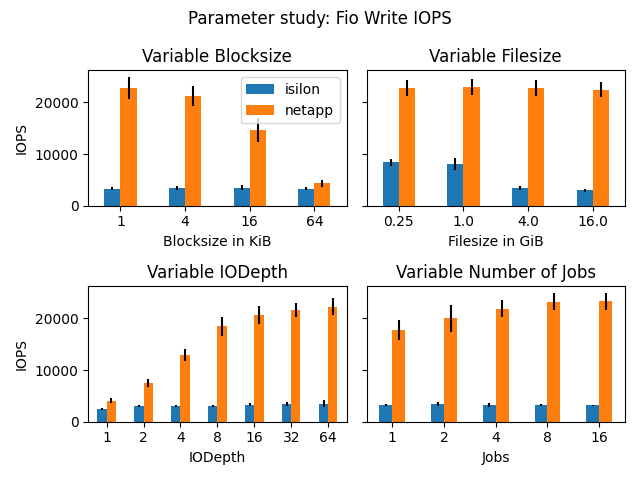

In [48]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T22:22:50_iops_write_")
folder = Path("./results/param_study_fio_iops")

## Plot code
path = file_prefix if file_prefix else folder


post_i = "_isilon.json"
post_n = "_netapp.json"
metric = METRIC["iops_write"]

df_1 = pd.concat({
    "isilon": load_data(path, suffix="blocksize"+post_i, metric=metric),
    "netapp": load_data(path, suffix="blocksize"+post_n, metric=metric),
})
df_2 = pd.concat({
    "isilon": load_data(path, suffix="filesize"+post_i, metric=metric),
    "netapp": load_data(path, suffix="filesize"+post_n, metric=metric),
})
df_3 = pd.concat({
    "isilon": load_data(path, suffix="iodepth"+post_i, metric=metric),
    "netapp": load_data(path, suffix="iodepth"+post_n, metric=metric),
})
df_4 = pd.concat({
    "isilon": load_data(path, suffix="numjobs"+post_i, metric=metric),
    "netapp": load_data(path, suffix="numjobs"+post_n, metric=metric),
})

fig, axis = plt.subplots(2, 2, sharey=True)
fig.suptitle('Parameter study: Fio Write IOPS')

    
df_1["mean"].unstack(level=0).plot(
    ax=axis[0][0],
    kind='bar', rot=0,
    xlabel='Blocksize in KiB',
    ylabel='IOPS',
    title='Variable Blocksize',
    yerr=df_1["conf"].unstack(level=0)
)
df_2["mean"].unstack(level=0).plot(
    ax=axis[0][1],
    kind='bar', rot=0,
    xlabel='Filesize in GiB',
    title='Variable Filesize',
    yerr=df_2["conf"].unstack(level=0)
)

df_3["mean"].unstack(level=0).plot(
    ax=axis[1][0],
    kind='bar', rot=0,
    xlabel='IODepth',
    ylabel='IOPS',
    title='Variable IODepth',
    yerr=df_3["conf"].unstack(level=0)
)

df_4["mean"].unstack(level=0).plot(
    ax=axis[1][1],
    kind='bar', rot=0,
    xlabel='Jobs',
    title='Variable Number of Jobs',
    yerr=df_4["conf"].unstack(level=0)
)

for i,j in [(0,1),(1,0),(1,1)]:
    axis[i][j].get_legend().remove()
    
plt.tight_layout()
plt.savefig("paramstudy_fio_iops.png",bbox_inches='tight')
plt.show()


# Experiment: Parameter-evaluation: S3Benchmark

<IPython.core.display.Javascript object>


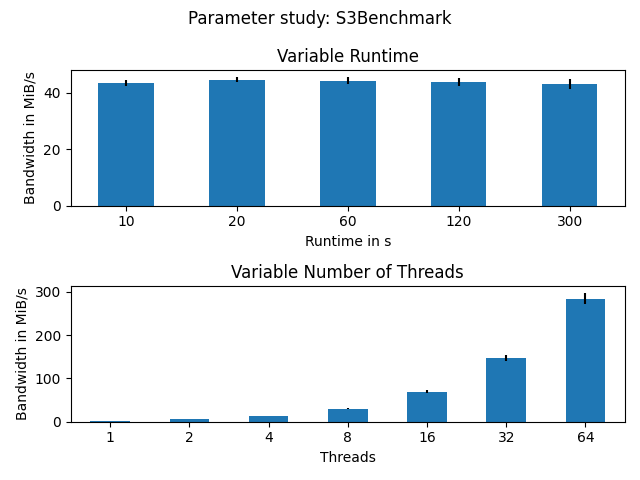

In [47]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-17T20:00:04_parameval_s3benchmark_")
folder = Path("./results/param_study_s3benchmark")

## Plot code
path = file_prefix if file_prefix else folder

metric = "put_bw_in_mibi"
df_1 = load_data(path, suffix="runtime.json", metric=metric)
df_2 = load_data(path, suffix="threads.json", metric=metric)

fig, axis = plt.subplots(2, 1)
fig.suptitle('Parameter study: S3Benchmark')

    
df_1["mean"].plot(
    ax=axis[0],
    kind='bar', rot=0,
    xlabel='Runtime in s',
    ylabel='Bandwidth in MiB/s',
    title='Variable Runtime',
    yerr=df_1["conf"]
)
df_2["mean"].plot(
    ax=axis[1],
    kind='bar', rot=0,
    xlabel='Threads',
    ylabel='Bandwidth in MiB/s',
    title='Variable Number of Threads',
    yerr=df_2["conf"]
)

plt.tight_layout()
plt.savefig("paramstudy_s3benchmark.png",bbox_inches='tight')
plt.show()


# Experiment: Parameter-evaluation: Warp

<IPython.core.display.Javascript object>


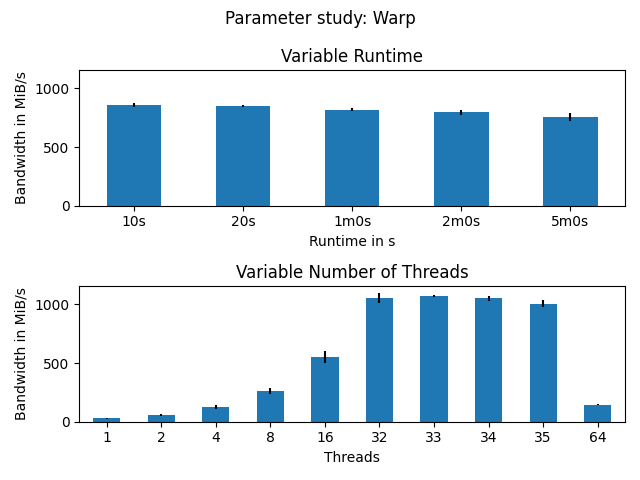

In [53]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-13T11:04:51_parameval_warp_")
folder = Path("./results/param_study_warp")

## Plot code
path = file_prefix if file_prefix else folder

metric = "put_bw_in_MiB"
df_1 = load_data(path, suffix="runtime.json", metric=metric)
df_2 = load_data(path, suffix="concurrent.json", metric=metric)

fig, axis = plt.subplots(2, 1, sharey=True)
fig.suptitle('Parameter study: Warp')

    
df_1["mean"].plot(
    ax=axis[0],
    kind='bar', rot=0,
    xlabel='Runtime in s',
    ylabel='Bandwidth in MiB/s',
    title='Variable Runtime',
    yerr=df_1["conf"]
)
df_2["mean"].plot(
    ax=axis[1],
    kind='bar', rot=0,
    xlabel='Threads',
    ylabel='Bandwidth in MiB/s',
    title='Variable Number of Threads',
    yerr=df_2["conf"]
)

plt.tight_layout()
plt.savefig("paramstudy_warp.png",bbox_inches='tight')
plt.show()


# Experiment: Compare dd and fio

<IPython.core.display.Javascript object>


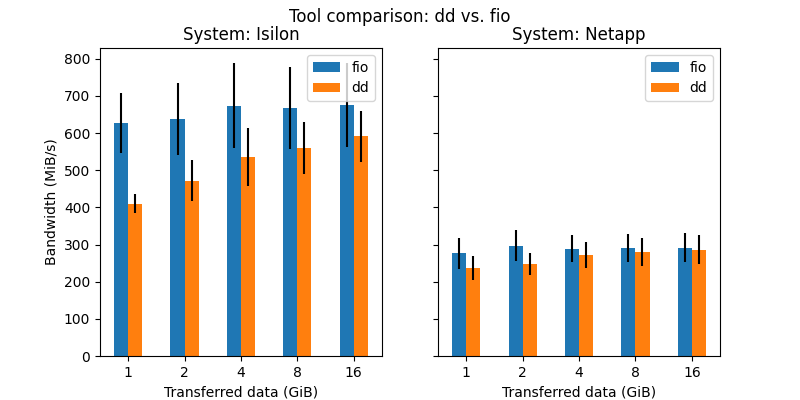

In [58]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-07-05T20:00:06_throughput_write_")
folder = Path("./results/compare_dd_vs_fio")

## Plot code
path = file_prefix if file_prefix else folder

df_isilon = pd.concat({
    "fio": load_data(path, metric="write_bw_mean_in_MiB", suffix="isilon_a.json"),
    "dd": load_data(path, metric="bw_in_MiB", suffix="isilon_b.json"),
})

df_netapp = pd.concat({
    "fio": load_data(path, metric="write_bw_mean_in_MiB", suffix="netapp_a.json"),
    "dd": load_data(path, metric="bw_in_MiB", suffix="netapp_b.json"),
})

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Tool comparison: dd vs. fio')

df_isilon["mean"].unstack(level=0).plot(
    ax=ax1,
    kind='bar', rot=0,
    xlabel='Transferred data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"System: Isilon",
    figsize=(8, 4),
    yerr=df_isilon["conf"].unstack(level=0)
)

df_netapp["mean"].unstack(level=0).plot(
    ax=ax2,
    kind='bar', rot=0,
    xlabel='Transferred data (GiB)',
    ylabel='Bandwidth (MiB/s)',
    title=f"System: Netapp",
    figsize=(8, 4),
    yerr=df_netapp["conf"].unstack(level=0)
)

plt.show()



# Experiment: Native vs Container

In [57]:
%matplotlib notebook

# Read in results
## Params - Either specify a file prefix or a whole folder
file_prefix = None # Path("./results/2022-05-31T21:42:26_con_vs_nativ_")
folder = Path("./results/compare_native_vs_container")

## Plot code
path = file_prefix if file_prefix else folder

def load_df(benchmark):

    df = pd.concat([
        load_data(path, suffix=benchmark+"_con.json", metric=METRIC[benchmark]).rename(index={"con_vs_nativ_"+benchmark+"_con": "container"}),
        load_data(path, suffix=benchmark+"_nativ.json", metric=METRIC[benchmark]).rename(index={"con_vs_nativ_"+benchmark+"_nativ": "nativ"}),
    ])

    return df
df_1 = load_df("throughput_write")
df_2 = load_df("iops_write")
df_3 = load_df("latency_write")
df_4 = load_df("throughput_read")
df_5 = load_df("iops_read")
df_6 = load_df("latency_read")

def extract(df):
    return (
        df.loc['nativ'].at['mean'],
        df.loc['nativ'].at['conf'],
        df.loc['container'].at['mean'],
        df.loc['container'].at['conf'],
    )

## {1}{2}{3}{4}
# 1: b=troughput, i=iops, l=latency
# 2: w=write, r=read
# 3: n=nativ, c=container
# 4: m=mean, c=conf
 
bwnm, bwnc, bwcm, bwcc = extract(df_1)
brnm, brnc, brcm, brcc = extract(df_4)
iwnm, iwnc, iwcm, iwcc = extract(df_2)
irnm, irnc, ircm, ircc = extract(df_5)
lwnm, lwnc, lwcm, lwcc = extract(df_3)
lrnm, lrnc, lrcm, lrcc = extract(df_6)


tex_table([
    ["", "", "\multicolumn{3}{c}{Native}", "\multicolumn{3}{c}{Container}"],
    ["Bandwidth (MiB/s)", "write", f"{bwnm:.0f}", "$\pm$", f"{bwnc:.0f}", f"{bwcm:.0f}", "$\pm$", f"{bwcc:.0f}"],
    [""                 , "read" , f"{brnm:.0f}", "$\pm$", f"{brnc:.0f}", f"{brcm:.0f}", "$\pm$", f"{brcc:.0f}"],
    ["IOPS (ops/s)"     , "write", f"{iwnm:.0f}", "$\pm$", f"{iwnc:.0f}", f"{iwcm:.0f}", "$\pm$", f"{iwcc:.0f}"],
    [""                 , "read" , f"{irnm:.0f}", "$\pm$", f"{irnc:.0f}", f"{ircm:.0f}", "$\pm$", f"{ircc:.0f}"],
    ["Latency (ms)"     , "write", f"{lwnm:.2f}", "$\pm$", f"{lwnc:.3f}", f"{lwcm:.2f}", "$\pm$", f"{lwcc:.3f}"],
    [""                 , "read" , f"{lrnm:.2f}", "$\pm$", f"{lrnc:.3f}", f"{lrcm:.2f}", "$\pm$", f"{lrcc:.3f}"],
])

 &  & \multicolumn{3}{c}{Native} & \multicolumn{3}{c}{Container}\\
Bandwidth (MiB/s) & write & 669 & $\pm$ & 129 & 652 & $\pm$ & 121\\
 & read & 543 & $\pm$ & 107 & 542 & $\pm$ & 105\\
IOPS (ops/s) & write & 3652 & $\pm$ & 403 & 3796 & $\pm$ & 397\\
 & read & 22705 & $\pm$ & 735 & 22624 & $\pm$ & 794\\
Latency (ms) & write & 1.02 & $\pm$ & 0.039 & 0.99 & $\pm$ & 0.029\\
 & read & 0.55 & $\pm$ & 0.015 & 0.55 & $\pm$ & 0.013\\


# Experiment: Compare S3Benchmark vs Warp

# Experiment: Daytime evaluation

Netapp & 217 & 539 & 383 & 4 & 55\\
 & 191 & 540 & 384 & 4 & 57\\
Isilon & 250 & 1036 & 791 & 13 & 172\\
 & 297 & 1034 & 785 & 14 & 172\\
S3 & 428 & 1110 & 1053 & 6 & 78\\
 & 715 & 1110 & 1055 & 6 & 70\\


<IPython.core.display.Javascript object>


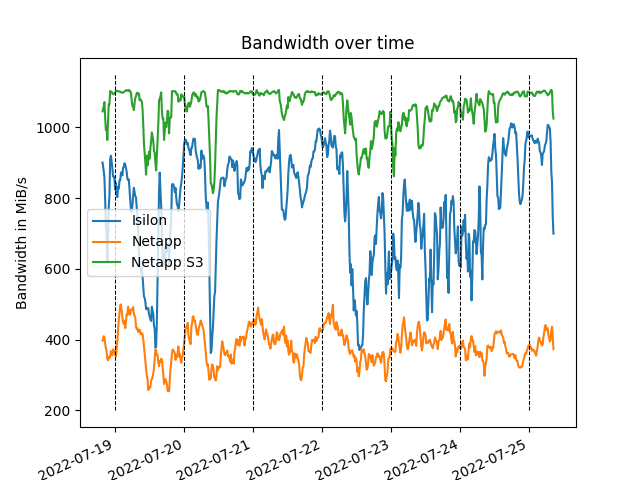

In [61]:
%matplotlib notebook

# Read in results
## Params
folder = Path("./results/daytime_eval")

## Plot code
res = {}


def _load():
    # res: dict[datetime, results]
    # results: dict[tuple[system, num], bw_in_MiB]
    for file in folder.iterdir():
        date_str, _, _, system, num = file.stem.split("_")
        date = datetime.fromisoformat(date_str) + timedelta(hours=2)
        file_content = json.loads(file.read_text())

        run_res = file_content["results"][f"daytime_evaluation_{system}_{num}"]
        if len(run_res) == 0:
            print("No result for:", date_str, system, num)
            continue
        if "put_bw_in_MiB" in run_res[0]:
            value = float(run_res[0]["put_bw_in_MiB"])
        else:
            value = run_res[0]["write_bw_mean_in_MiB"] 

        if date not in res:
            res[date] = {}

        key = (system, int(num))
        if key in res:
            print("Duplication for:", date, key)
        res[date][key] = value

    labels = sorted(k for k in res.keys())
    return labels, res

def generate_tex_table(labels, res):
    # Generate values for tex-table
    values_netapp_1 = []
    values_netapp_2 = []
    values_isilon_1 = []
    values_isilon_2 = []
    values_s3_1 = []
    values_s3_2 = []

    for key in labels:
        value = res[key]
        values_netapp_1.append(value.get(("netapp", 1), 0))
        values_netapp_2.append(value.get(("netapp", 2), 0))
        values_isilon_1.append(value.get(("isilon", 1), 0))
        values_isilon_2.append(value.get(("isilon", 2), 0))
        values_s3_1.append(value.get(("s3", 1), 0))
        values_s3_2.append(value.get(("s3", 2), 0))

    def extract_stats(values, label=""):
        min_, max_ = min(values), max(values)
        avg, conf = sum(values)/len(values), confidence_interval(values)
        std = np.std(values)
        print(f"{label} & {min_:.0f} & {max_:.0f} & {avg:.0f} & {conf:.0f} & {std:.0f}\\\\")

    extract_stats(values_netapp_1, "Netapp")
    extract_stats(values_netapp_2)
    extract_stats(values_isilon_1, "Isilon")
    extract_stats(values_isilon_2)
    extract_stats(values_s3_1, "S3")
    extract_stats(values_s3_2)

def generate_plot(labels, res):
    # Generate plot
    values_netapp_1 = []
    values_netapp_2 = []
    values_isilon_1 = []
    values_isilon_2 = []
    values_s3_1 = []
    values_s3_2 = []
    ## Sliding windows
    sw_netapp_1 = []
    sw_netapp_2 = []
    sw_isilon_1 = []
    sw_isilon_2 = []
    sw_s3_1 = []
    sw_s3_2 = []

    def calc_sliding_window(value, sw):
        width = 4
        sw.append(value)
        if len(sw) > width:
            sw.pop(0)
        return sum(sw)/len(sw)

    for key in labels:
        value = res[key]
        values_netapp_1.append(calc_sliding_window(value.get(("netapp", 1), 0),sw_netapp_1))
        values_netapp_2.append(calc_sliding_window(value.get(("netapp", 2), 0),sw_netapp_2))
        values_isilon_1.append(calc_sliding_window(value.get(("isilon", 1), 0),sw_isilon_1))
        values_isilon_2.append(calc_sliding_window(value.get(("isilon", 2), 0),sw_isilon_2))
        values_s3_1.append(calc_sliding_window(value.get(("s3", 1), 0),sw_s3_1))
        values_s3_2.append(calc_sliding_window(value.get(("s3", 2), 0),sw_s3_2))

    #plt.plot(labels, values_isilon_1, label="Isilon 01")
    #plt.plot(labels, values_netapp_1, label="Netapp 01")
    #plt.plot(labels, values_s3_1, label="S3 01")
    plt.plot(labels, values_isilon_2, label="Isilon")
    plt.plot(labels, values_netapp_2, label="Netapp")
    plt.plot(labels, values_s3_2, label="Netapp S3")

    # Plot day seperation lines
    for month, day in [(7,19),(7,20),(7,21),(7,22),(7,23),(7,24),(7,25)]:
        x = datetime(year=2022, month=month, day=day)
        plt.vlines(x=x, ymin=200, ymax=1150, linewidth=2, linestyles="dashed", colors="k", linewidths=0.75)
        #x_8, x_17 = x.replace(hour=8), x.replace(hour=17)
        #plt.axvspan(x_8, x_17, color='red', alpha=0.25)

    plt.xticks(rotation=25, ha='right')
    plt.ylabel('Bandwidth in MiB/s')

    plt.legend()
    plt.title("Bandwidth over time")
    plt.savefig("daytime_evaluation.png",bbox_inches='tight')
    plt.show()

labels, res = _load()
generate_tex_table(labels, res)
generate_plot(labels, res)


## Experiment: Compare isilon vs. netapp vs. fuse vs. davrods

In [6]:
## Params
result_file_prefix = "2022-04-18T15:21:17_benchmark"
result_file_prefix = "2022-04-19T08:01:46_benchmark"
result_file_prefix = "2022-04-19T22:44:52_benchmark"
result_file_prefix1 = "2022-04-24T22:07:21_benchmark"
result_file_prefix2 = "2022-05-10T07:02:12_benchmark"

## Plot code
data_isilon1 = load_json(f"../results/{result_file_prefix1}_isilon.json")
data_isilon2 = load_json(f"../results/{result_file_prefix2}_isilon.json")
#data_netapp = load_json(f"../results/{result_file_prefix}_netapp.json")
#data_irods_fuse = load_json(f"../results/{result_file_prefix}_irods_fuse_on_isilon.json")
#data_irods_davrods = load_json(f"../results/{result_file_prefix}_irods_davrods_on_isilon.json")
#data_irods_fuse_s3 = load_json(f"../results/{result_file_prefix}_irods_fuse_on_s3.json")

benchmarks = [
    ("throughput_write", "write_bw_mean_in_mb"),
    ("throughput_read", "read_bw_mean_in_mb"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]

for label, metric in benchmarks:
    df = pd.concat([
        extract_results(data_isilon1, metric, [label]),
        extract_results(data_isilon2, metric, [label]),
        #extract_results(data_netapp, metric, [label]),
        #extract_results(data_irods_fuse, metric, [label]),
        #extract_results(data_irods_davrods, metric, [label]),
        #extract_results(data_irods_fuse_s3, metric, [label]),
    ])
    print(df)




                        mean      conf
throughput_write   99.023088  0.619379
throughput_write  126.583062  3.420939
                       mean       conf
throughput_read  100.434809   9.754372
throughput_read  370.962375  27.413739
                   mean         conf
iops_write  3348.945972   406.854599
iops_write  4532.409169  1176.419927
                   mean        conf
iops_read  20517.825104  383.174700
iops_read  17253.772118  867.350218
                   mean      conf
latency_write  0.960222  0.023121
latency_write  1.890200  0.114710
                  mean      conf
latency_read  0.536071  0.012775
latency_read  0.708808  0.032046


In [7]:
## Params
result_file_prefix = "2022-04-18T15:21:17_benchmark"

## Plot code
data_isilon = load_json(f"../results/{result_file_prefix}_isilon.json")
data_netapp = load_json(f"../results/{result_file_prefix}_netapp.json")
data_irods_fuse = load_json(f"../results/{result_file_prefix}_irods_fuse_on_isilon.json")

benchmarks = [
    ("throughput_write", "write_bw_mean_in_mb"),
    ("throughput_read", "read_bw_mean_in_mb"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]

for label, metric in benchmarks:
    df = pd.concat([
        extract_results(data_isilon, metric, [label]),
        extract_results(data_netapp, metric, [label]),
        extract_results(data_irods_fuse, metric, [label]),
    ])
    print(df)



                        mean      conf
throughput_write   98.685998  0.068802
throughput_write   98.482835  0.161289
throughput_write  134.952795  1.269093
                      mean      conf
throughput_read  95.881488  3.320839
throughput_read  94.468629  0.365485
throughput_read  99.994432  0.126420
                    mean         conf
iops_write   3710.599657  1095.649276
iops_write  13774.541151  1368.937597
iops_write    794.592284     1.286878
                   mean         conf
iops_read  19207.208368   402.272921
iops_read  15687.604135  2593.205149
iops_read    800.625000     0.074255
                   mean      conf
latency_write  1.038045  0.042719
latency_write  3.042860  0.488825
latency_write  1.983074  0.226385
                  mean      conf
latency_read  0.534238  0.010611
latency_read  4.522136  0.547462
latency_read  2.701251  0.333236


In [8]:
## Params
result_file_prefix = "2022-04-25T15:47:32_mdtest"

## Plot code
data_isilon = load_json(f"../results/{result_file_prefix}_isilon.json")
data_netapp = load_json(f"../results/{result_file_prefix}_netapp.json")
data_irods_fuse = load_json(f"../results/{result_file_prefix}_irods_fuse_on_isilon.json")
data_irods_davrods = load_json(f"../results/{result_file_prefix}_irods_davrods_on_isilon.json")

metrics = [
    "dir_create",
    "dir_stat",
    "dir_rename",
    "dir_remove",
    "file_create",
    "file_stat",
    "file_read",
    "file_remove",
    "tree_create",
    "tree_remove",
]

for metric in metrics:
    print(metric)
    df = pd.concat([
        extract_results(data_isilon, metric),
        extract_results(data_netapp, metric),
        extract_results(data_irods_fuse, metric),
        extract_results(data_irods_davrods, metric),
    ])
    print(df)
    print()


dir_create
                                    mean        conf
mdtest_isilon                   195.0692  105.290020
mdtest_netapp                   137.5430   57.419667
mdtest_irods_fuse_on_isilon      44.7016    6.878651
mdtest_irods_davrods_on_isilon   56.1538    6.073183

dir_stat
                                       mean           conf
mdtest_isilon                   458066.2202  155468.307392
mdtest_netapp                   345333.3616  167402.243800
mdtest_irods_fuse_on_isilon     498550.5862   66372.716515
mdtest_irods_davrods_on_isilon   91911.9392   21695.084993

dir_rename
                                    mean        conf
mdtest_isilon                   421.5754  375.125824
mdtest_netapp                   136.0700   40.062452
mdtest_irods_fuse_on_isilon      42.1128    5.173145
mdtest_irods_davrods_on_isilon   36.1058    4.252653

dir_remove
                                    mean        conf
mdtest_isilon                   206.9110  206.691646
mdtest_netapp           

## Experiment: Effect of daytime

In [26]:
# Read in results
## Params
folder = Path("./results/daytime_eval_2")

## Plot code
res = {}

# res: dict[datetime, results]
# results: dict[tuple[system, num], bw_in_MiB]
for file in folder.iterdir():
    date_str, _, _, system, num = file.stem.split("_")
    date = datetime.fromisoformat(date_str) + timedelta(hours=2)
    file_content = json.loads(file.read_text())
    
    run_res = file_content["results"][f"daytime_evaluation_{system}_{num}"]
    if len(run_res) == 0:
        print("No result for:", date_str, system, num)
        continue
    if "put_bw_in_MiB" in run_res[0]:
        value = float(run_res[0]["put_bw_in_MiB"])
    else:
        value = run_res[0]["write_bw_mean_in_MiB"] 

    if date not in res:
        res[date] = {}

    key = (system, int(num))
    if key in res:
        print("Duplication for:", date, key)
    res[date][key] = value

labels = sorted(k for k in res.keys())

In [27]:
# Generate values for tex-table
values_netapp_1 = []
values_netapp_2 = []
values_isilon_1 = []
values_isilon_2 = []
values_s3_1 = []
values_s3_2 = []

for key in labels:
    value = res[key]
    values_netapp_1.append(value.get(("netapp", 1), 0))
    values_netapp_2.append(value.get(("netapp", 2), 0))
    values_isilon_1.append(value.get(("isilon", 1), 0))
    values_isilon_2.append(value.get(("isilon", 2), 0))
    values_s3_1.append(value.get(("s3", 1), 0))
    values_s3_2.append(value.get(("s3", 2), 0))

def extract_stats(values, label=""):
    min_, max_ = min(values), max(values)
    avg, conf = sum(values)/len(values), confidence_interval(values)
    std = np.std(values)
    print(f"{label} & {min_:.0f} & {max_:.0f} & {avg:.0f} & {conf:.0f} & {std:.0f}\\\\")

extract_stats(values_netapp_1, "Netapp")
extract_stats(values_netapp_2)
extract_stats(values_isilon_1, "Isilon")
extract_stats(values_isilon_2)
extract_stats(values_s3_1, "S3")
extract_stats(values_s3_2)


Netapp & 217 & 539 & 383 & 4 & 55\\
 & 191 & 540 & 384 & 4 & 57\\
Isilon & 250 & 1036 & 791 & 13 & 172\\
 & 297 & 1034 & 785 & 14 & 172\\
S3 & 428 & 1110 & 1053 & 6 & 78\\
 & 715 & 1110 & 1055 & 6 & 70\\


<IPython.core.display.Javascript object>


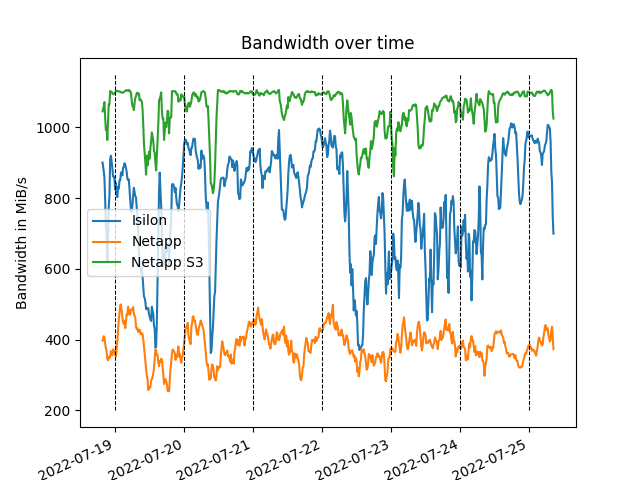

In [36]:
%matplotlib notebook
# Generate plot
values_netapp_1 = []
values_netapp_2 = []
values_isilon_1 = []
values_isilon_2 = []
values_s3_1 = []
values_s3_2 = []
## Sliding windows
sw_netapp_1 = []
sw_netapp_2 = []
sw_isilon_1 = []
sw_isilon_2 = []
sw_s3_1 = []
sw_s3_2 = []

def calc_sliding_window(value, sw):
    width = 4
    sw.append(value)
    if len(sw) > width:
        sw.pop(0)
    return sum(sw)/len(sw)

for key in labels:
    value = res[key]
    values_netapp_1.append(calc_sliding_window(value.get(("netapp", 1), 0),sw_netapp_1))
    values_netapp_2.append(calc_sliding_window(value.get(("netapp", 2), 0),sw_netapp_2))
    values_isilon_1.append(calc_sliding_window(value.get(("isilon", 1), 0),sw_isilon_1))
    values_isilon_2.append(calc_sliding_window(value.get(("isilon", 2), 0),sw_isilon_2))
    values_s3_1.append(calc_sliding_window(value.get(("s3", 1), 0),sw_s3_1))
    values_s3_2.append(calc_sliding_window(value.get(("s3", 2), 0),sw_s3_2))

#plt.plot(labels, values_isilon_1, label="Isilon 01")
#plt.plot(labels, values_netapp_1, label="Netapp 01")
#plt.plot(labels, values_s3_1, label="S3 01")
plt.plot(labels, values_isilon_2, label="Isilon")
plt.plot(labels, values_netapp_2, label="Netapp")
plt.plot(labels, values_s3_2, label="Netapp S3")

# Plot day seperation lines
for month, day in [(7,19),(7,20),(7,21),(7,22),(7,23),(7,24),(7,25)]:
    x = datetime(year=2022, month=month, day=day)
    plt.vlines(x=x, ymin=200, ymax=1150, linewidth=2, linestyles="dashed", colors="k", linewidths=0.75)
    #x_8, x_17 = x.replace(hour=8), x.replace(hour=17)
    #plt.axvspan(x_8, x_17, color='red', alpha=0.25)

plt.xticks(rotation=25, ha='right')
plt.ylabel('Bandwidth in MiB/s')

plt.legend()
plt.title("Bandwidth over time")
plt.savefig("daytime_evaluation.png",bbox_inches='tight')
plt.show()


                      mean        conf
fio+isilon1 1   273.541730   36.237419
            2   264.637403   23.393714
            4   325.938544   48.026264
            8   342.520034   31.725740
            16  244.056200   97.941468
dd+isilon1  1   162.000000   19.494520
            2   296.400000   85.411683
            4   513.000000   69.127350
            8   637.000000   41.040705
            16  667.200000   25.813475
fio+isilon2 1   299.729644   30.333704
            2   241.121954   11.655913
            4   268.859686   49.703140
            8   286.053682   15.841805
            16  244.464008   33.248627
dd+isilon2  1   220.400000   14.091656
            2   221.000000   18.227526
            4   268.000000   20.777013
            8   265.600000   15.120796
            16  267.200000   13.297984
fio+isilon3 1   206.552128  103.590367
            2   272.064510  189.339545
            4   298.899818  175.276442
            8   322.927844  435.591907
            16  357.68497

<IPython.core.display.Javascript object>


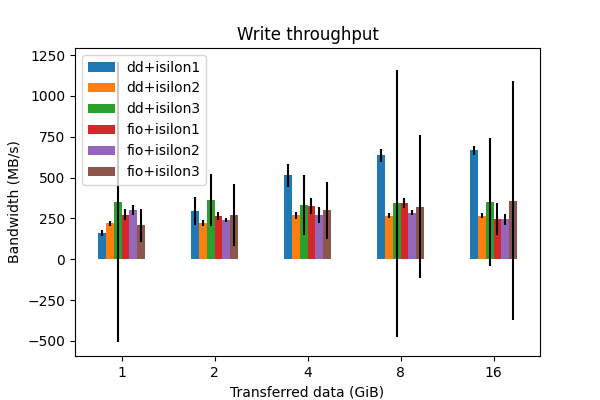

In [11]:
%matplotlib notebook
## Params
pre1 = "2022-05-16T09:47:54_throughput_write_"
pre2 = "2022-05-16T12:29:40_throughput_write_"
pre3 = "2022-05-16T14:05:12_throughput_write_"

## Plot code
pre = result_file_prefix
df = pd.concat({
    "fio+isilon1": load_data(f"../results/{pre1}fio_isilon.json", "write_bw_mean_in_mb"),
    "dd+isilon1": load_data(f"../results/{pre1}dd_isilon.json", "bw_in_mb"),
    "fio+isilon2": load_data(f"../results/{pre2}fio_isilon.json", "write_bw_mean_in_mb"),
    "dd+isilon2": load_data(f"../results/{pre2}dd_isilon.json", "bw_in_mb"),
    "fio+isilon3": load_data(f"../results/{pre3}fio_isilon.json", "write_bw_mean_in_mb"),
    "dd+isilon3": load_data(f"../results/{pre3}dd_isilon.json", "bw_in_mb"),
    #"fio+netapp": load_data(f"../results/{pre}fio_netapp.json", "write_bw_mean_in_mb"),
    #"dd+netapp": load_data(f"../results/{pre}dd_netapp.json", "bw_in_mb"),
})
df.rename(index={"1G": 1, "2G": 2, "4G": 4, "8G": 8, "16G": 16}, inplace=True)
df.rename(index={"1024": 1, "2048": 2, "4096": 4, "8192": 8, "16384": 16}, inplace=True)
print(df)

ax = df["mean"].unstack(level=0).plot(
    kind='bar', rot=0,
    xlabel='Transferred data (GiB)',
    ylabel='Bandwidth (MB/s)',
    title='Write throughput',
    figsize=(6, 4),
    yerr=df["conf"].unstack(level=0)
)
plt.show()


<IPython.core.display.Javascript object>


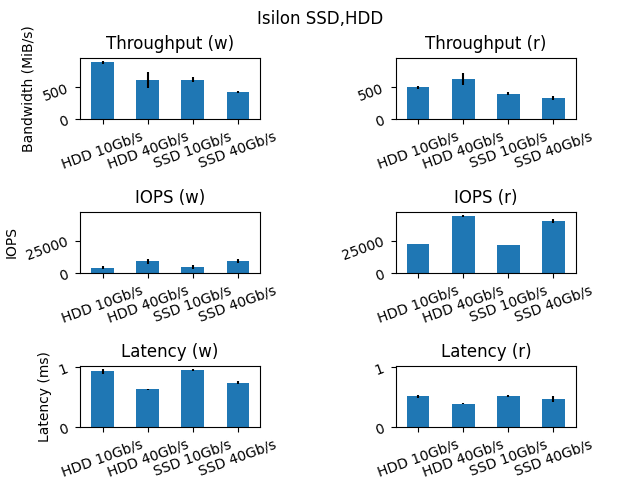

---------
Throughput write
                  mean        conf
HDD 10Gb/s  878.803601   25.972890
HDD 40Gb/s  600.292803  121.679785
SSD 10Gb/s  606.877758   36.888629
SSD 40Gb/s  421.088637   12.693389
---------
Throughput read
                  mean       conf
HDD 10Gb/s  492.820954  26.868541
HDD 40Gb/s  621.963134  91.321449
SSD 10Gb/s  395.877308  24.737324
SSD 40Gb/s  327.628254  31.461114
---------
IOPS write
                   mean         conf
HDD 10Gb/s  4318.617123  1305.729139
HDD 40Gb/s  9052.378237  2016.837904
SSD 10Gb/s  4953.676898  1558.063893
SSD 40Gb/s  9609.892948  1577.719669
---------
IOPS read
                    mean         conf
HDD 10Gb/s  22353.215900   259.821755
HDD 40Gb/s  43927.077824   963.282209
SSD 10Gb/s  21739.072803   214.043431
SSD 40Gb/s  40184.774059  1650.376162
---------
Latency write
                mean      conf
HDD 10Gb/s  0.936706  0.038311
HDD 40Gb/s  0.636252  0.007878
SSD 10Gb/s  0.958689  0.023377
SSD 40Gb/s  0.745047  0.024791
-------

In [48]:
%matplotlib notebook

## Params
result_file_prefix = "2022-06-08T19:53:53_benchmark"

## Plot code
hdd_s = load_json(f"./results/{result_file_prefix}_isilon_hdd.json")
hdd_f = load_json(f"./results/{result_file_prefix}_isilon_hdd_fast.json")
ssd_s = load_json(f"./results/{result_file_prefix}_isilon_ssd.json")
ssd_f = load_json(f"./results/{result_file_prefix}_isilon_ssd_fast.json")

benchmarks = [
    ("throughput_write", "write_bw_mean_in_MiB"),
    ("throughput_read", "read_bw_mean_in_MiB"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]

dfs = []
for label, metric in benchmarks:
    dfs.append(pd.concat([
        extract_results(hdd_s, metric, [label]).rename(index={label: "HDD 10Gb/s"}),
        extract_results(hdd_f, metric, [label]).rename(index={label: "HDD 40Gb/s"}),
        extract_results(ssd_s, metric, [label]).rename(index={label: "SSD 10Gb/s"}),
        extract_results(ssd_f, metric, [label]).rename(index={label: "SSD 40Gb/s"}),
    ]))

    
fig, axis = plt.subplots(3, 2)
fig.suptitle('Isilon SSD,HDD')
plt.subplots_adjust(wspace=0.7500, hspace=1.5)
    
dfs[0]["mean"].plot(
    ax=axis[0][0],
    kind='bar', rot=0,
    ylabel='Bandwidth (MiB/s)',
    title='Throughput (w)',
    yerr=dfs[0]["conf"],
)
dfs[1]["mean"].plot(
    ax=axis[0][1],
    kind='bar', rot=0,
    title='Throughput (r)',
    yerr=dfs[1]["conf"],
)

dfs[2]["mean"].plot(
    ax=axis[1][0],
    kind='bar', rot=0,
    ylabel='IOPS',
    title='IOPS (w)',
    yerr=dfs[2]["conf"]
)

dfs[3]["mean"].plot(
    ax=axis[1][1],
    kind='bar', rot=0,
    title='IOPS (r)',
    yerr=dfs[3]["conf"],
)
dfs[4]["mean"].plot(
    ax=axis[2][0],
    kind='bar', rot=0,
    ylabel='Latency (ms)',
    title='Latency (w)',
    yerr=dfs[4]["conf"]
)
dfs[5]["mean"].plot(
    ax=axis[2][1],
    kind='bar', rot=0,
    title='Latency (r)',
    yerr=dfs[5]["conf"],
)

axis[0][1].sharey(axis[0][0])
axis[1][0].sharey(axis[1][1])
axis[2][1].sharey(axis[2][0])
for i,j in [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]:
    axis[i][j].tick_params(labelrotation=20)
    # axis[i][j].get_legend().remove()
    
#plt.tight_layout()
# plt.savefig("paramstudy_throughput.png",bbox_inches='tight')
plt.show()

print("---------", "Throughput write", sep="\n")
print(dfs[0])
print("---------", "Throughput read", sep="\n")
print(dfs[1])
print("---------", "IOPS write", sep="\n")
print(dfs[2])
print("---------", "IOPS read", sep="\n")
print(dfs[3])
print("---------", "Latency write", sep="\n")
print(dfs[4])
print("---------", "Latency read", sep="\n")
print(dfs[5])

